<a href="https://colab.research.google.com/github/072arushi/mnist-classification-using-SVM-and-CNN/blob/main/mnist_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **MNIST CLASSIFICATION USING SVM and CNN**

**By-**
**Arushi Garg, ECE- 2nd year**
**07201022020**

I developed a model using Support Vector Machine and Convolutional Neural Network which correctly classified the handwritten digits from 0-9 based on the pixel values given as features. Thus, this is a 10-class classification problem.

For this problem, we used the MNIST data which is a large database of handwritten digits. The 'pixel values' of each digit (image) comprise the features, and the actual number between 0-9 is the label.

Since each image is of 28 x 28 pixels, and each pixel forms a feature, there are 784 features. MNIST digit recognition is a well-studied problem in the ML community, and people have trained numerous models (Neural Networks, SVMs, boosted trees etc.) achieving error rates as low as 0.23% (i.e. accuracy = 99.77%, with a convolutional neural network). This dataset is taken from Kaggle.

In [ ]:
### importing the libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model
from sklearn.model_selection import train_test_split
import gc
import cv2

## Dataset Importing

In [1]:
### mounting the drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
### importing the dataset
digits = pd.read_csv("/content/drive/MyDrive/train.csv")
digits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42000 entries, 0 to 41999
Columns: 785 entries, label to pixel783
dtypes: int64(785)
memory usage: 251.5 MB


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
### printing the first 5 rows of the dataset
digits.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,...,pixel744,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
print(digits.iloc[3, 1:])

pixel0      0
pixel1      0
pixel2      0
pixel3      0
pixel4      0
           ..
pixel779    0
pixel780    0
pixel781    0
pixel782    0
pixel783    0
Name: 3, Length: 784, dtype: int64


In [ ]:
four = digits.iloc[3, 1:]
four.shape

(784,)

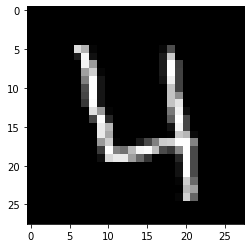

In [ ]:
four = four.values.reshape(28, 28)
plt.imshow(four, cmap='gray')

In [ ]:
### visualising the array
print(four[5:-5, 5:-5])

[[  0 220 179   6   0   0   0   0   0   0   0   0   9  77   0   0   0   0]
 [  0  28 247  17   0   0   0   0   0   0   0   0  27 202   0   0   0   0]
 [  0   0 242 155   0   0   0   0   0   0   0   0  27 254  63   0   0   0]
 [  0   0 160 207   6   0   0   0   0   0   0   0  27 254  65   0   0   0]
 [  0   0 127 254  21   0   0   0   0   0   0   0  20 239  65   0   0   0]
 [  0   0  77 254  21   0   0   0   0   0   0   0   0 195  65   0   0   0]
 [  0   0  70 254  21   0   0   0   0   0   0   0   0 195 142   0   0   0]
 [  0   0  56 251  21   0   0   0   0   0   0   0   0 195 227   0   0   0]
 [  0   0   0 222 153   5   0   0   0   0   0   0   0 120 240  13   0   0]
 [  0   0   0  67 251  40   0   0   0   0   0   0   0  94 255  69   0   0]
 [  0   0   0   0 234 184   0   0   0   0   0   0   0  19 245  69   0   0]
 [  0   0   0   0 234 169   0   0   0   0   0   0   0   3 199 182  10   0]
 [  0   0   0   0 154 205   4   0   0  26  72 128 203 208 254 254 131   0]
 [  0   0   0   0  61 254

In [ ]:
### Summarising the counts of 'label' to see how many labels of each digit are present
digits.label.value_counts()

1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: label, dtype: int64

In [ ]:
### Summarise count in terms of percentage 
100*(round(digits.label.astype('category').value_counts()/len(digits.index), 4))

1    11.15
7    10.48
3    10.36
9     9.97
2     9.95
6     9.85
0     9.84
4     9.70
8     9.67
5     9.04
Name: label, dtype: float64

Thus, each digit/label has an approximately 9%-11% fraction in the dataset and the dataset is balanced.

In [ ]:
### average values/distributions of features
description = digits.describe()
description

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,...,pixel744,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
count,42000.000000,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.00000,42000.000000,42000.000000,42000.000000,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.000000,42000.000000,42000.000000,42000.000000,42000.000000,42000.000000,42000.000000,...,42000.000000,42000.000000,42000.000000,42000.000000,42000.000000,42000.000000,42000.000000,42000.000000,42000.000000,42000.000000,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.000000,42000.000000,42000.000000,42000.000000,42000.000000,42000.000000,42000.000000,42000.000000,42000.000000,42000.000000,42000.00000,42000.000000,42000.000000,42000.000000,42000.000000,42000.000000,42000.00000,42000.000000,42000.000000,42000.0,42000.0,42000.0,42000.0
mean,4.456643,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00300,0.011190,0.005143,0.000214,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000381,0.001310,0.010548,0.027262,0.050905,0.066405,0.129571,...,3.772524,2.748905,1.796452,1.089905,0.563190,0.239571,0.093524,0.024833,0.000857,0.001405,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.006143,0.035833,0.082357,0.114905,0.178714,0.301452,0.413643,0.513667,0.558833,0.677857,0.60281,0.489238,0.340214,0.219286,0.117095,0.059024,0.02019,0.017238,0.002857,0.0,0.0,0.0,0.0
std,2.887730,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.56812,1.626927,1.053972,0.043916,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.078072,0.232634,1.131661,2.310396,3.121847,3.259128,4.992894,...,26.957829,22.879248,18.595109,14.434439,10.517823,6.469315,3.976306,1.846016,0.139556,0.287891,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.949803,2.350859,3.934280,4.543583,5.856772,7.219742,8.928286,10.004069,10.129595,11.254931,10.69603,9.480066,7.950251,6.312890,4.633819,3.274488,1.75987,1.894498,0.414264,0.0,0.0,0.0,0.0
min,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
25%,2.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
50%,4.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,

### **Data Preparation for Model Building**

In [ ]:
### Creating training and test sets
### Splitting the data into train and test
X = digits.iloc[:, 1:]
Y = digits.iloc[:, 0]

### Rescaling the features
from sklearn.preprocessing import scale
X = scale(X)

### train test split with train_size=90% and test size=10%
x_train, x_test, y_train, y_test = train_test_split(X, Y, train_size=0.90, random_state=101)
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(37800, 784)
(4200, 784)
(37800,)
(4200,)


## Model building


### **Linear SVM**

In [ ]:
from sklearn import svm
from sklearn import metrics

### an initial SVM model with linear kernel   
svm_linear = svm.SVC(kernel='linear')

### fit
svm_linear.fit(x_train, y_train)

SVC(kernel='linear')

In [ ]:
### predicting
predictions = svm_linear.predict(x_test)
predictions[:10]

array([1, 3, 0, 0, 1, 9, 1, 5, 0, 6])

In [ ]:
### evaluation: accuracy
### C(i, j) represents the number of points known to be in class i 
### but predicted to be in class j
print(x_test)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [ ]:
### confusion matrix
confusion = metrics.confusion_matrix(y_true = y_test, y_pred = predictions)
confusion

array([[399,   0,   0,   1,   1,   4,   2,   0,   1,   1],
       [  0, 442,   2,   0,   1,   0,   0,   0,   2,   1],
       [  2,   9, 376,   6,   6,   6,   4,   3,   4,   0],
       [  1,   1,  13, 372,   2,  11,   0,   2,   8,   6],
       [  3,   1,   1,   1, 379,   2,   4,   1,   2,  17],
       [  3,   2,   4,  14,   6, 321,   6,   0,   7,   2],
       [  2,   2,   1,   0,   1,   6, 413,   0,   2,   0],
       [  0,   2,   4,   2,  11,   1,   0, 401,   0,  16],
       [  4,   8,   7,  17,   3,  11,   2,   3, 355,   6],
       [  5,   1,   4,   5,  22,   2,   0,  16,   3, 397]])

In [ ]:
### measuring accuarcy
metrics.accuracy_score(y_true=y_test, y_pred=predictions)

0.9178571428571428

**Accuracy achieved using linear SVM= 91.78%**

In [ ]:
### determining class wise accuracy
class_wise = metrics.classification_report(y_true=y_test, y_pred=predictions)
print(class_wise)

              precision    recall  f1-score   support

           0       0.95      0.98      0.96       409
           1       0.94      0.99      0.97       448
           2       0.91      0.90      0.91       416
           3       0.89      0.89      0.89       416
           4       0.88      0.92      0.90       411
           5       0.88      0.88      0.88       365
           6       0.96      0.97      0.96       427
           7       0.94      0.92      0.93       437
           8       0.92      0.85      0.89       416
           9       0.89      0.87      0.88       455

    accuracy                           0.92      4200
   macro avg       0.92      0.92      0.92      4200
weighted avg       0.92      0.92      0.92      4200



### **Non-linear SVM**

In [ ]:
### rbf kernel with other hyperparameters kept to default 
svm_rbf = svm.SVC(kernel='rbf')
svm_rbf.fit(x_train, y_train)

SVC()

In [ ]:
### predict
predictions = svm_rbf.predict(x_test)

### accuracy 
print(metrics.accuracy_score(y_true=y_test, y_pred=predictions))

0.9576190476190476


**Accuracy achieved using Non-linear SVM= 95.7%**

## **Convolutional Neural Network (CNN)**

In [ ]:
### importing libraries
from keras.layers import *
from keras.activations import *
from keras.models import *
from keras.optimizers import *
from keras.initializers import *
from keras.callbacks import *

from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical

In [ ]:
x = digits.drop(['label'], 1).values
y = digits['label'].values


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  """Entry point for launching an IPython kernel.


In [ ]:
y = to_categorical(y)
print(f"Label size {y.shape}")

Label size (42000, 10, 2)


In [ ]:
x = x / 255.0
x_test = x_test / 255.0

In [ ]:
### reshaping the data
x= x.reshape(-1,28,28,1)
x_test = x_test.reshape(-1,28,28,1)

In [ ]:
y = to_categorical(y)

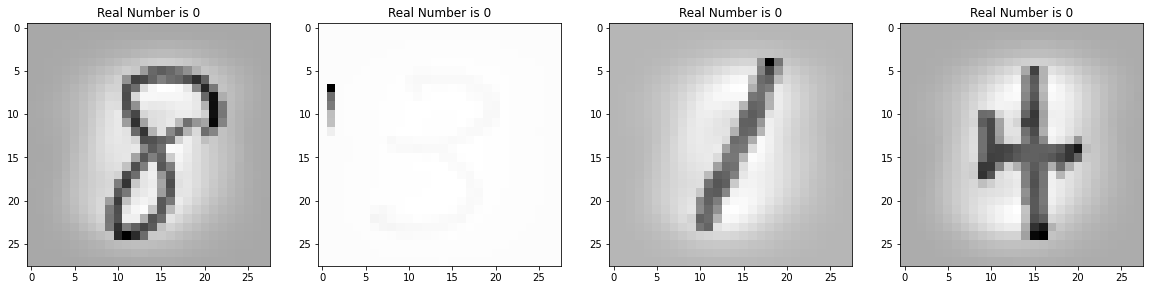

In [ ]:
x_train__ = x_train.reshape(x_train.shape[0], 28, 28)

fig, axis = plt.subplots(1, 4, figsize=(20, 10))
for i, ax in enumerate(axis.flat):
    ax.imshow(x_train__[i], cmap='binary')
    digit = y_train[i].argmax()
    ax.set(title = f"Real Number is {digit}");

In [ ]:
mean = np.mean(x_train)
std = np.std(x_train)

def standardize(x):
    return (x-mean)/std

In [ ]:
### deciding number of epochs and batch_size
epochs = 50
batch_size = 64

In [ ]:
### preparing the model
model=Sequential()

model.add(Lambda(standardize,input_shape=(28,28,1)))    
model.add(Conv2D(filters=64, kernel_size = (3,3), activation="relu", input_shape=(28,28,1)))
model.add(Conv2D(filters=64, kernel_size = (3,3), activation="relu"))

model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())
model.add(Conv2D(filters=128, kernel_size = (3,3), activation="relu"))
model.add(Conv2D(filters=128, kernel_size = (3,3), activation="relu"))

model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())    
model.add(Conv2D(filters=256, kernel_size = (3,3), activation="relu"))
    
model.add(MaxPooling2D(pool_size=(2,2)))
    
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(512,activation="relu"))
    
model.add(Dense(10,activation="softmax"))
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

In [ ]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images


In [ ]:
### Fitting in the model
model.fit(x, y, batch_size=batch_size, validation_split=0.2, epochs=10)

Epoch 1/10
525/525 [==============================] - 259s 490ms/step - loss: 0.1068 - accuracy: 0.9669 - val_loss: 0.0960 - val_accuracy: 0.9708
Epoch 2/10
525/525 [==============================] - 255s 486ms/step - loss: 0.0471 - accuracy: 0.9858 - val_loss: 0.0609 - val_accuracy: 0.9817
Epoch 3/10
525/525 [==============================] - 255s 486ms/step - loss: 0.0326 - accuracy: 0.9898 - val_loss: 0.0710 - val_accuracy: 0.9782
Epoch 4/10
525/525 [==============================] - 255s 485ms/step - loss: 0.0262 - accuracy: 0.9915 - val_loss: 0.0448 - val_accuracy: 0.9890
Epoch 5/10
525/525 [==============================] - 253s 483ms/step - loss: 0.0231 - accuracy: 0.9926 - val_loss: 0.0466 - val_accuracy: 0.9880
Epoch 6/10
525/525 [==============================] - 252s 480ms/step - loss: 0.0236 - accuracy: 0.9930 - val_loss: 0.0404 - val_accuracy: 0.9907
Epoch 7/10
525/525 [==============================] - 252s 480ms/step - loss: 0.0173 - accuracy: 0.9943 - val_loss: 0.0622 -

In [ ]:
### predict
predictions = model.predict(x_test)
print(predictions)

[[3.2736925e-06 9.9999130e-01 1.8941283e-07 ... 1.1041112e-06
  1.5409917e-06 1.5334828e-06]
 [3.4555108e-06 9.9999070e-01 2.1251124e-07 ... 1.2458454e-06
  1.6606956e-06 1.6784185e-06]
 [3.3558445e-06 9.9999118e-01 1.9953011e-07 ... 1.1560859e-06
  1.5679717e-06 1.5089855e-06]
 ...
 [3.2844309e-06 9.9999130e-01 1.9081305e-07 ... 1.1108031e-06
  1.5523967e-06 1.5480929e-06]
 [3.4429816e-06 9.9999082e-01 2.0322882e-07 ... 1.2443198e-06
  1.6185248e-06 1.6304974e-06]
 [3.4646246e-06 9.9999070e-01 2.0195749e-07 ... 1.2429889e-06
  1.6489054e-06 1.6351610e-06]]


**Accuracy achieved using the CNN model= 99.02%**

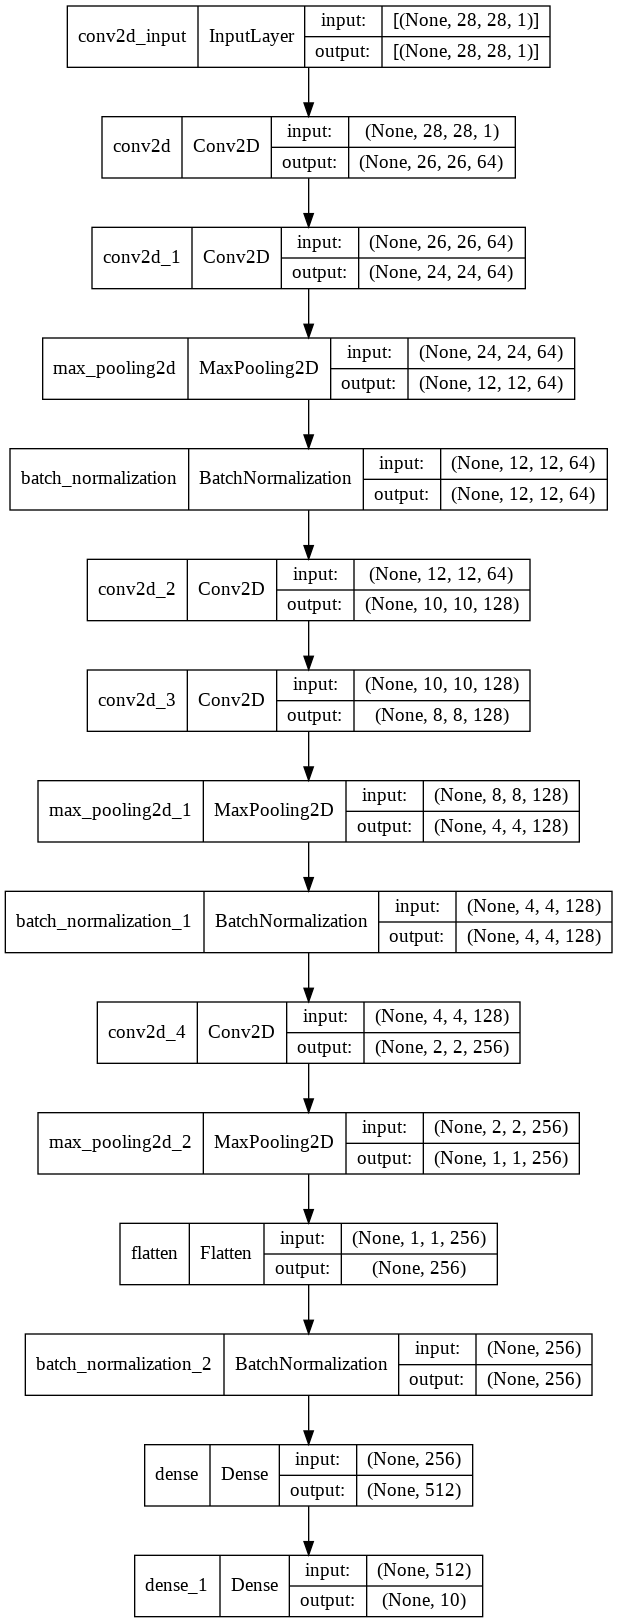

In [ ]:
### Plotting the model
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

## **Predicting the value of the digit**

### Prediction using SVM model

In [ ]:
### importing libraries
from PIL import Image

In [ ]:
### uploading the image and resizing it
size = 28,28
image1='/content/drive/MyDrive/download.png'
im = Image.open(image1)
im_resized = im.resize(size, Image.ANTIALIAS)
im_resized.save("down.png","PNG")

In [ ]:
print(im_resized)

<PIL.Image.Image image mode=P size=28x28 at 0x7F9751829DD0>


In [ ]:
###importing libraries
from numpy import argmax
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array

In [ ]:
### reshaping
img = cv2.imread("down.png",0)  
img = img / 255.0
img = np.reshape(img,(1, 784)) 
svm_linear.predict(img)

array([2])

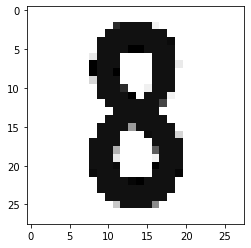

In [ ]:
### ploting the image
img = cv2.imread("down.png",0) 
img = np.reshape(img,(28, 28))
plt.imshow(img, cmap='gray')

In [ ]:
print(img)

[[255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255
  255 255 255 255 255 255 255 255 255 255]
 [255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255
  255 255 255 255 255 255 255 255 255 255]
 [255 255 255 255 255 255 255 255 255 255 255  43  17  17  17  17 242 255
  255 255 255 255 255 255 255 255 255 255]
 [255 255 255 255 255 255 255 255 255 255  17  17  17  17  17  17  17  17
  255 255 255 255 255 255 255 255 255 255]
 [255 255 255 255 255 255 255 255 255  17  17  17  17  17  17  17  17  17
   11 255 255 255 255 255 255 255 255 255]
 [255 255 255 255 255 255 255 255 255  17  17  17  17   0   0  17  17  17
   17 255 255 255 255 255 255 255 255 255]
 [255 255 255 255 255 255 255 255 234  17  17  17 255 255 255 255  17  17
   17 255 255 255 255 255 255 255 255 255]
 [255 255 255 255 255 255 255 255   0  17  17  17 255 255 255 255  17  17
   17 234 255 255 255 255 255 255 255 255]
 [255 255 255 255 255 255 255 255   0  17  17   0 255 255 255 25

In [ ]:
### load the image
#img = load_img("down.png", grayscale=True, target_size=(28, 28))

### convert to array
img = img_to_array(img)

### reshape into a single sample with 1 channel
img = img.reshape(1, 784)

### prepare pixel data
img = img.astype('float32')
img = img / 255.0

In [ ]:
print(img)

[[1.         1.         1.         1.         1.         1.
  1.         1.         1.         1.         1.         1.
  1.         1.         1.         1.         1.         1.
  1.         1.         1.         1.         1.         1.
  1.         1.         1.         1.         1.         1.
  1.         1.         1.         1.         1.         1.
  1.         1.         1.         1.         1.         1.
  1.         1.         1.         1.         1.         1.
  1.         1.         1.         1.         1.         1.
  1.         1.         1.         1.         1.         1.
  1.         1.         1.         1.         1.         1.
  1.         0.16862746 0.06666667 0.06666667 0.06666667 0.06666667
  0.9490196  1.         1.         1.         1.         1.
  1.         1.         1.         1.         1.         1.
  1.         1.         1.         1.         1.         1.
  1.         1.         1.         1.         0.06666667 0.06666667
  0.06666667 0.06666667 

In [ ]:
### predicting -the value of the printed image using the SVM model
predict_value=svm_rbf.predict(img)
digit = argmax(predict_value)
print(digit)

0


In [ ]:
### printing the predicted value of the input image
print(predict_value)

[8]


### Prediction using CNN model

In [ ]:
### predicting using CNN model
img_width, img_height = 28, 28
img = load_img('/content/drive/MyDrive/download.png',False,target_size=(img_width,img_height))
w = img_to_array(img)
w = np.expand_dims(w, axis=0)
preds = model.predict_classes(w)
prob = model.predict_proba(w)
print(preds, prob)
